<font color="blue">Forecasting Animal Diseases to Inform Prevention and Public Action</font>

To become a proactive organization, SafeLivestock anticipates threats of animal disease epidemics. It employs use of predictive technique to forecast animal diseases. The use case was used to predict and create awareness for better preparedness in case of emergencies. Communities provides food millions to millions of households, hence a food security resource.

Predicting animal diseases can help prevent or mitigate the impact of the diseases which spread even to humans. By predicting the likelihood of disease outbreaks, authorities can take preventive measures such as vaccination programs, biosecurity measures, and movement restrictions, which can help reduce the spread of diseases among animals.



Business Solution:
To tackle these challenges,

Our use case centres around conducting a time-series analysis of animal diseases, factoring in various dimensions such as region, animal type, and specific diseases, along with their various combinations. Furthermore, it incorporates a dynamic selection process, enabling the user to choose the dimensions on which the predictions will be based.

Disease forecast and analysis per Region per Animal

# Project Objective

  Tutorial Methodology

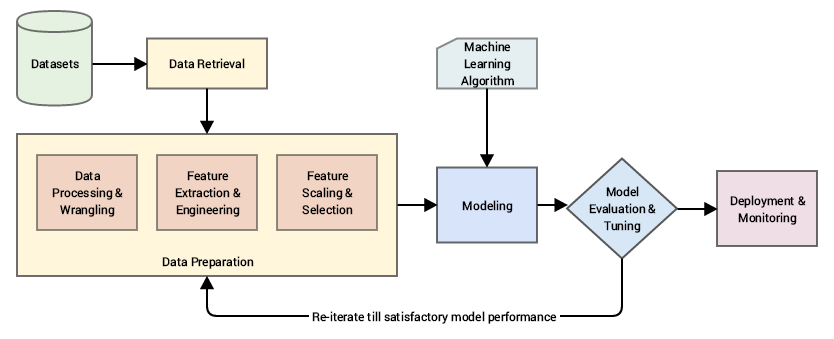

  Introduce the project. This project is geared towards ...

# 1. EE Python Configuration

This section will help us set up the EE Python API to get started. Follow the below steps to get ready.

In [30]:

# Install some Important libraries
!pip install earthengine-api geemap folium
!pip install geemap
!pip install geojson

In [31]:
# Import GEE preprocessing libraries
import ee
import geemap
import folium
from IPython.display import display
# Other DS preprocessing libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import warnings
warnings.simplefilter('ignore')
from urllib.error import HTTPError


##### <font color="blue">Run code below</font>

Initial Step


Earth Engine requires users to log in and authorize access to data and processing capabilities in the cloud.

We'll have to authenticate the current session with Google Earth Engine (GEE).
It will prompt the user to authenticate through their Google account, allowing access to Earth Engine resources.

Upon execution, a web browser window will open to log in with Google credentials and grant the necessary permissions.

After authentication, we use the Initialization command which sets up the environment to interact with the Earth Engine API and specifies the project under which this session will run.

For our case, the project ID is 'yourgooglecloudprojectid', which refers to the user's cloud project within Earth Engine.

Initialization allows subsequent code to access datasets, perform analyses, and execute Earth Engine functions within the context of the specified project.

In [32]:
# Authenticate the session to EE Cloud project
ee.Authenticate()
# Initialize the GEE session
ee.Initialize(project='yourgooglecloudprojectid')

##### <font color="blue">Defining Area of Interest</font>

In [33]:
# Define Kenya's coordinates
kenya_coordinates = [-1.2921, 36.8219] # longitude (x) then latitude (y)

# Create a geemap Map centered on Kenya
Map = geemap.Map(center=kenya_coordinates, zoom=6)

# Display the map
Map

Map(center=[-1.2921, 36.8219], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

##### <font color="blue">Accessing ImageCollection</font>

In [34]:
# Accessing EO dataset
# Load Sentinel-2 imagery
image_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2023-01-01', '2023-12-31') \
    .filterBounds(ee.Geometry.Point([-1.2921, 36.8219]))  # Kenya's coordinates

image = image_collection.first()


In [35]:
# Create a map centered at the point of interest (e.g., Nairobi)
Map = geemap.Map(center=[-1.2921, 36.8219], zoom=10)

# Add the image to the map with visualization parameters
visualization_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}
Map.addLayer(image, visualization_params, 'Sentinel-2 Image')

# Display the map
Map

Map(center=[-1.2921, 36.8219], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

Import In-situ data

This is sample dataset of climate data used to predict the prevalence of a disease.

In [36]:
# Read in situ data
df = pd.read_csv('/content/animal_disease_forecasting_data.csv')
df.head(3)

,Date,African Country,Temperature (°C),Humidity (%),NDVI,Soil Moisture (%),Livestock Density (per km²),Disease Incidence,Vector Population (per km²),Vaccination Rate (%),Outbreak Risk (1-5),Disease Name,Symptoms
0,10/31/2011,South Africa,30.053580,68.245794,0.836698,34.625830,54.621787,506,325.496799,91.123808,4,Rift Valley Fever,Nasal discharge and salivation
1,8/31/2017,Kenya,34.929828,70.980406,0.545410,28.223808,14.545044,989,441.971125,83.417378,1,Anthrax,Bloody discharge
2,5/31/2012,Ethiopia,39.713009,56.338285,0.396378,30.201279,17.996249,956,217.394012,39.554311,3,East Coast Fever,Enlarged lymph nodes


## 2. Exploratory Spatial Analysis

In [37]:
df.shape

(2000, 13)

In [39]:
# df.dtypes

From the above output it means, there are a mixture of categorical and numerical variables in the dataset.

Categorical variables have data type object. Numerical variables have data type int64.

So we've to deal with categorical variables for better analysis.

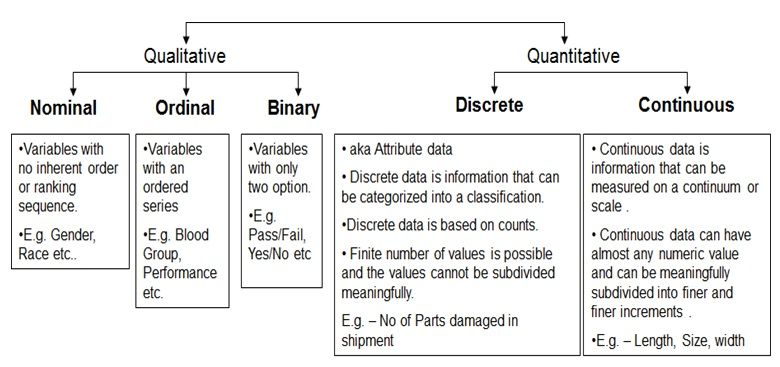

#### <font color="blue">Check the categorical Columns</font>

In [40]:
cate_cols = df['African Country'].unique()
cate_cols

array(['South Africa', 'Kenya', 'Ethiopia', 'Tanzania', 'Uganda'],
      dtype=object)

In [41]:
# Let's see which cols are categorical
cate_cols = df.select_dtypes(include=['object'])
cate_cols.head(20)

,Date,African Country,Disease Name,Symptoms
0,10/31/2011,South Africa,Rift Valley Fever,Nasal discharge and salivation
1,8/31/2017,Kenya,Anthrax,Bloody discharge
2,5/31/2012,Ethiopia,East Coast Fever,Enlarged lymph nodes
3,1/31/2011,South Africa,Lumpy Skin Disease,Nodules on the skin
4,2/28/2010,South Africa,Anthrax,Bloody discharge
5,5/31/2012,Ethiopia,East Coast Fever,Enlarged lymph nodes
6,3/31/2012,Tanzania,Anthrax,Bloody discharge
7,2/28/2014,Ethiopia,Avian Influenza,Respiratory distress
8,11/30/2017,Kenya,Anthrax,Bloody discharge
9,7/31/2022,Kenya,Lumpy Skin Disease,Nodules on the skin


#### <font color="blue">Check the Disease Prevalence</font>

In [42]:
# Examine disease prevalence
Disease_Prevalence = df.groupby("Disease Name")["Outbreak Risk (1-5)"].sum().reset_index()
Disease_Prevalence

,Disease Name,Outbreak Risk (1-5)
0,Anthrax,1070
1,Avian Influenza,1310
2,East Coast Fever,1310
3,Lumpy Skin Disease,1313
4,Rift Valley Fever,1257


#### <font color="blue">Check the cols Stastical Distribution</font>

In [43]:
# We can see that the above df.describe().T command presents statistical properties in horizontal form.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (°C),2000.0,30.381696,5.752361,20.101232,25.572929,30.593012,35.232392,39.801077
Humidity (%),2000.0,58.361617,17.415903,30.650259,41.747468,58.450430,72.875755,89.430309
NDVI,2000.0,0.465982,0.220427,0.116057,0.267479,0.445328,0.634046,0.891968
Soil Moisture (%),2000.0,22.151930,10.283065,5.162121,12.346696,22.442872,30.775548,39.890599
Livestock Density (per km²),2000.0,52.794631,28.818858,2.088587,27.599059,54.409638,80.079540,99.795477
Disease Incidence,2000.0,534.995000,294.437400,1.000000,300.000000,552.000000,788.000000,993.000000
Vector Population (per km²),2000.0,241.111213,128.803428,5.506172,128.397956,242.714825,327.849660,496.074525
Vaccination Rate (%),2000.0,57.695986,23.914515,10.232561,38.104461,60.403419,78.867178,99.400324
Outbreak Risk (1-5),2000.0,3.130000,1.411062,1.000000,2.000000,3.000000,4.000000,5.000000


## 3. Visualization and Reporting

#### <font color="blue">Objective 1: Which Country has high disease prevalance</font>

In [45]:
Countr_Disease_prevalence=df.groupby(['African Country'])[['Disease Incidence','Outbreak Risk (1-5)']].mean().reset_index().sort_values('Disease Incidence',ascending=False) # Changed tuple to list and corrected column name
Countr_Disease_prevalence[['African Country','Disease Incidence']].head(n=10)

,African Country,Disease Incidence
3,Tanzania,604.870690
1,Kenya,569.550136
0,Ethiopia,553.447525
2,South Africa,535.369231
4,Uganda,415.067010



#### <font color="blue">Objective 2: What's the Disease Outbreak risk level in each season?</font>

In [46]:
# Group by 'African Country' and count the occurrences of 'Disease Name'
# To do this we'll do a feature engineering step to create a seasons column then add it to the dataset
# Sample DataFrame
data = pd.read_csv('/content/animal_disease_forecasting_data.csv')
df1 = pd.DataFrame(data)

# Convert 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'])

# Function to classify seasons
def classify_season(date):
    month = date.month
    if month in [11, 12, 1]:  # Winter
        return 'Winter'
    elif month in [2, 3, 4]:  # Spring
        return 'Spring'
    elif month in [5, 6, 7]:  # Summer
        return 'Summer'
    elif month in [8, 9, 10]: # Autumn
        return 'Autumn'

# Apply the function to create a new 'Seasons' column
df1['Seasons'] = df1['Date'].apply(classify_season)

# Display the updated DataFrame
df1.head()

,Date,African Country,Temperature (°C),Humidity (%),NDVI,Soil Moisture (%),Livestock Density (per km²),Disease Incidence,Vector Population (per km²),Vaccination Rate (%),Outbreak Risk (1-5),Disease Name,Symptoms,Seasons
0,2011-10-31,South Africa,30.053580,68.245794,0.836698,34.625830,54.621787,506,325.496799,91.123808,4,Rift Valley Fever,Nasal discharge and salivation,Autumn
1,2017-08-31,Kenya,34.929828,70.980406,0.545410,28.223808,14.545044,989,441.971125,83.417378,1,Anthrax,Bloody discharge,Autumn
2,2012-05-31,Ethiopia,39.713009,56.338285,0.396378,30.201279,17.996249,956,217.394012,39.554311,3,East Coast Fever,Enlarged lymph nodes,Summer
3,2011-01-31,South Africa,27.272592,37.623631,0.265067,13.697120,76.596974,975,276.947725,99.400324,4,Lumpy Skin Disease,Nodules on the skin,Winter
4,2010-02-28,South Africa,37.214612,35.638916,0.479169,37.894124,34.839918,458,297.793542,92.681002,4,Anthrax,Bloody discharge,Spring


In [47]:
# Now how many cols do we have
# Check columns present
column_names = df1.columns
column_names

Index(['Date', 'African Country', 'Temperature (°C)', 'Humidity (%)', 'NDVI',
       'Soil Moisture (%)', 'Livestock Density (per km²)', 'Disease Incidence',
       'Vector Population (per km²)', 'Vaccination Rate (%)',
       'Outbreak Risk (1-5)', 'Disease Name', 'Symptoms', 'Seasons'],
      dtype='object')

In [48]:
# Now we can answer our question..Whats the disease prevalence per season?
Regional_Disease_Prevalence = df1.groupby(["Disease Name", "Seasons"])["Outbreak Risk (1-5)"].sum().reset_index()
Regional_Disease_Prevalence

# Scale to Risk ranges 1-5

,Disease Name,Seasons,Outbreak Risk (1-5)
0,Anthrax,Autumn,274
1,Anthrax,Spring,149
2,Anthrax,Summer,242
3,Anthrax,Winter,405
4,Avian Influenza,Autumn,272
5,Avian Influenza,Spring,469
6,Avian Influenza,Summer,308
7,Avian Influenza,Winter,261
8,East Coast Fever,Autumn,235
9,East Coast Fever,Spring,448


#### <font color="blue">Objective 3: Which season should we likely expect high cases of which disease?</font>

In [49]:
# Group by Disease Name and Season, then sum the Outbreak Risk
Regional_Disease_Prevalence = df1.groupby(["Seasons", "Disease Name"])["Outbreak Risk (1-5)"].sum().reset_index()

# Find the disease with the highest outbreak risk per season
Most_Prevalent_Disease = Regional_Disease_Prevalence.loc[Regional_Disease_Prevalence.groupby("Seasons")["Outbreak Risk (1-5)"].idxmax()].reset_index(drop=True)
Most_Prevalent_Disease

,Seasons,Disease Name,Outbreak Risk (1-5)
0,Autumn,Lumpy Skin Disease,341
1,Spring,Avian Influenza,469
2,Summer,Rift Valley Fever,418
3,Winter,Anthrax,405


#### <font color="blue">Objective 4: How are the disease distributed per country?</font>


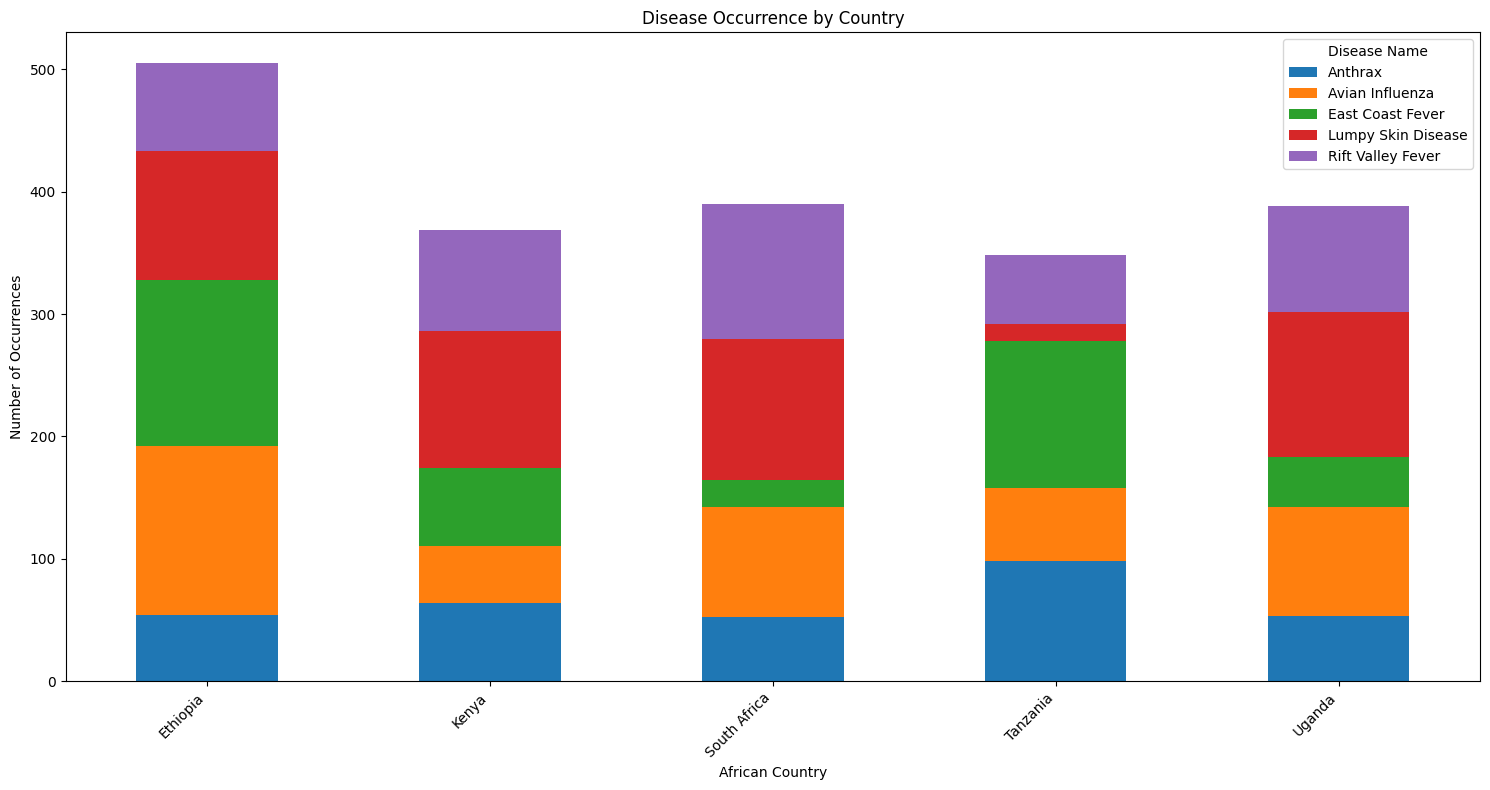

In [50]:
# Group by 'African Country' and 'Disease Name' and count occurrences
disease_counts = df1.groupby(['African Country', 'Disease Name'])['Disease Name'].count().unstack()

# Create the stacked bar chart
disease_counts.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Disease Occurrence by Country')
plt.xlabel('African Country')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Disease Name')
plt.tight_layout()
plt.show()


## 3. Prediction


#### <font color="blue">Objective 5: Predict which disease is likely to occur in a Region</font>



In [51]:
# Define feature columns and target
X = df1[['African Country', 'Temperature (°C)', 'Humidity (%)',
        'NDVI', 'Soil Moisture (%)', 'Livestock Density (per km²)',
        'Disease Incidence', 'Vector Population (per km²)',
        'Vaccination Rate (%)', 'Outbreak Risk (1-5)', 'Symptoms', 'Seasons']]  # Features

y = df1['Disease Name']  # Target

# Convert categorical columns into numerical data using one-hot encoding
X = pd.get_dummies(X, columns=['African Country', 'Symptoms', 'Seasons'], drop_first=False)


In [ ]:
# grouped_data = X.groupby(['African Country', 'Seasons']).mean()

In [52]:
print(X.shape)

(2000, 23)


In [53]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Train a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [55]:
model_accuracy = model.score(X_test, y_test)
print("Model Accuracy:" , model_accuracy * 100 , "%")

Model Accuracy: 100.0 %


In [56]:
# Make predictions
y_pred = model.predict(X_test_scaled)
#y_pred

In [57]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 1.0


In [58]:
# Saving model
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "disease_classifier_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

In [59]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)

# evaluate model
y_predict = model.predict(X_test)

# check results
print(classification_report(y_test, y_predict))

                    precision    recall  f1-score   support

           Anthrax       1.00      1.00      1.00        54
   Avian Influenza       1.00      1.00      1.00        84
  East Coast Fever       1.00      1.00      1.00        77
Lumpy Skin Disease       1.00      1.00      1.00       101
 Rift Valley Fever       1.00      1.00      1.00        84

          accuracy                           1.00       400
         macro avg       1.00      1.00      1.00       400
      weighted avg       1.00      1.00      1.00       400

